# Analyze performance of LSTM (Model 1) on Shasta Reservoir

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Data Processing

In [2]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [3]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])

In [4]:
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear

In [5]:
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

In [6]:
# Run data processing pipeline
pipeline = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train, ts_val, ts_test = pipeline.process_data(df) 

In [7]:
## Separate inputs(X) and targets (y)

# select inflow and doy as input features
X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, [0, 3]]
# select outflow as target feature
y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, [1]]

In [8]:
# Create PyTorch dataset and dataloader
dataset_train, dataset_val = (TensorDataset(X_train, y_train), TensorDataset(X_val, y_val))
# shuffle = False to preserve time order
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                     DataLoader(dataset_val, batch_size=1, shuffle=False))

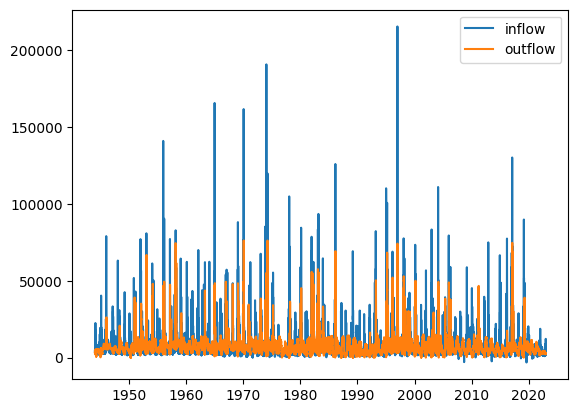

In [9]:
plt.plot(df.inflow)
plt.plot(df.outflow)
plt.legend(['inflow', 'outflow'])

## Analyze Optimal Hyperparameters
Previously, we conducted a grid search over a predefined parameter space: \
Hidden size (LSTM): 30, 35, 40, 45, 50\
Hidden size (FF): 30, 35, 40, 45, 50\
Dropout probability: 0.3, 0.5, 0.7

On 3 random seeds: 0, 10, 100, which we want to average performance over.


In [10]:
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *

In [11]:
# load in results from grid search
grid_df = pd.read_csv('report/results/hyperparameter_tuning/model1_tuning.csv', index_col=0)

In [15]:
# average performance over the random seeds
grid_df['param_id'] = np.repeat(np.arange(int(len(grid_df) / 3)), 3)
grid_df_mean = grid_df.groupby('param_id').mean()
grid_df_mean.drop(columns=['random_seed'], inplace=True)

In [21]:
# save sorted df
grid_df_mean.sort_values(by=['val_error'], axis=0, inplace=True)
grid_df_mean.to_csv('report/results/hyperparameter_tuning/model1_avg_tuning.csv')

In [23]:
grid_df_mean[:10]

,num_layers,hidden1,hidden2,dropout,epochs_trained,val_error
param_id,,,,,,
66,1.0,40.0,40.0,0.3,58.000000,0.369791
30,1.0,35.0,30.0,0.3,53.000000,0.373531
129,1.0,50.0,45.0,0.3,62.666667,0.376326
0,1.0,30.0,30.0,0.3,60.666667,0.377535
9,1.0,30.0,45.0,0.3,54.333333,0.378363
39,1.0,35.0,45.0,0.3,72.333333,0.380863
93,1.0,45.0,35.0,0.3,64.666667,0.380883
120,1.0,50.0,30.0,0.3,61.000000,0.381583
123,1.0,50.0,35.0,0.3,53.000000,0.382295


## Train model based on optimal hyperparameters
Number  of LSTM layers: 1\
LSTM hidden units: 40\
FF hidden units: 40\
dropout: 0.3

In [24]:
# instantiate model
input_size = 2
hidden_size1 = 40
hidden_size2 = 40
output_size = 1
dropout_prob = 0.3
num_layers = 1

torch.manual_seed(0)
model1 = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [25]:
# run training loop and get validation error
train_losses, val_losses = training_loop(model=model1, criterion=criterion, optimizer=optimizer, 
                                         patience=10, dataloader_train=dataloader_train, dataloader_val=dataloader_val, epochs=200)

Training epochs:  26%|██▌       | 52/200 [05:01<14:18,  5.80s/it]


In [28]:
# save model
torch.save(model1.state_dict(), 'src/models/saved_models/model1.pt')

In [29]:
# load saved model
model1.load_state_dict(torch.load('src/models/saved_models/model1.pt'))

<All keys matched successfully>

In [26]:
final_error(val_losses)

Final validation loss: 0.4059135814507802, Epochs trained: 53


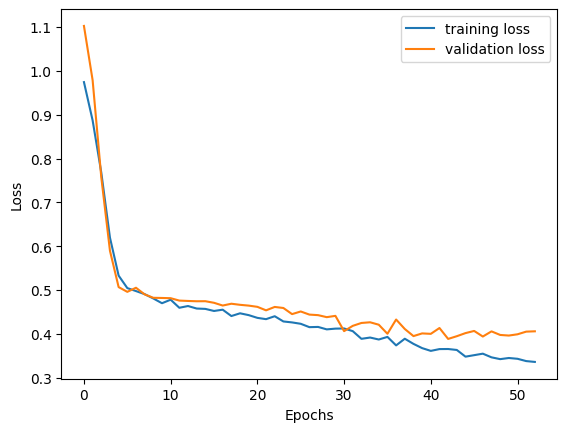

In [27]:
plot_train_val(train_losses, val_losses)